# Compute derivatives of the Prediction (on Omega or Omega_h)

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

## Imports

In [2]:
from scar.utils import read_config,create_tree,get_class
from scar.equations.run_Eikonal2D import *
from scar.equations.run_EikonalLap2D import *
from scar.geometry import Geometry2D

# from scar.solver.solver_fem import FEMSolver
# from scar.solver.solver_phifem import PhiFemSolver
# from scar.correction.correct_pred import *

import torch
from torch.autograd import grad as grad_torch
import dolfin as df
from dolfin import FunctionSpace,Function

import matplotlib.pyplot as plt

Using device: cpu
torch loaded; device is cpu


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


## Define case

In [3]:
form = "Pumpkin"
num_config = 1
sdf_run = run_EikonalLap2D

In [4]:
dir_name = "../networks/EikonalLap2D/"+form+"/"
models_dir = dir_name+"models/"
config_filename = models_dir+"config_"+str(num_config)+".json"
model_filename = models_dir+"model_"+str(num_config)+".pth"
derivees_dir = dir_name+"derivees/"
create_tree(derivees_dir)

In [5]:
geom_class = get_class(form,Geometry2D)
form = geom_class()

## Récupération du modèle

bc_points.shape = (2000, 2), bc_normals.shape = (2000, 2)
ICIIIII : tv_loss_f =  MSELoss()
>> load network /home/flecourtier/Bureau/Thèse/networks/EikonalLap2D/Pumpkin/models/model_1.pth
norm_grad_norm_gradu : torch.Size([20000, 1])
norm_grad_norm_gradu : torch.Size([20000, 1])


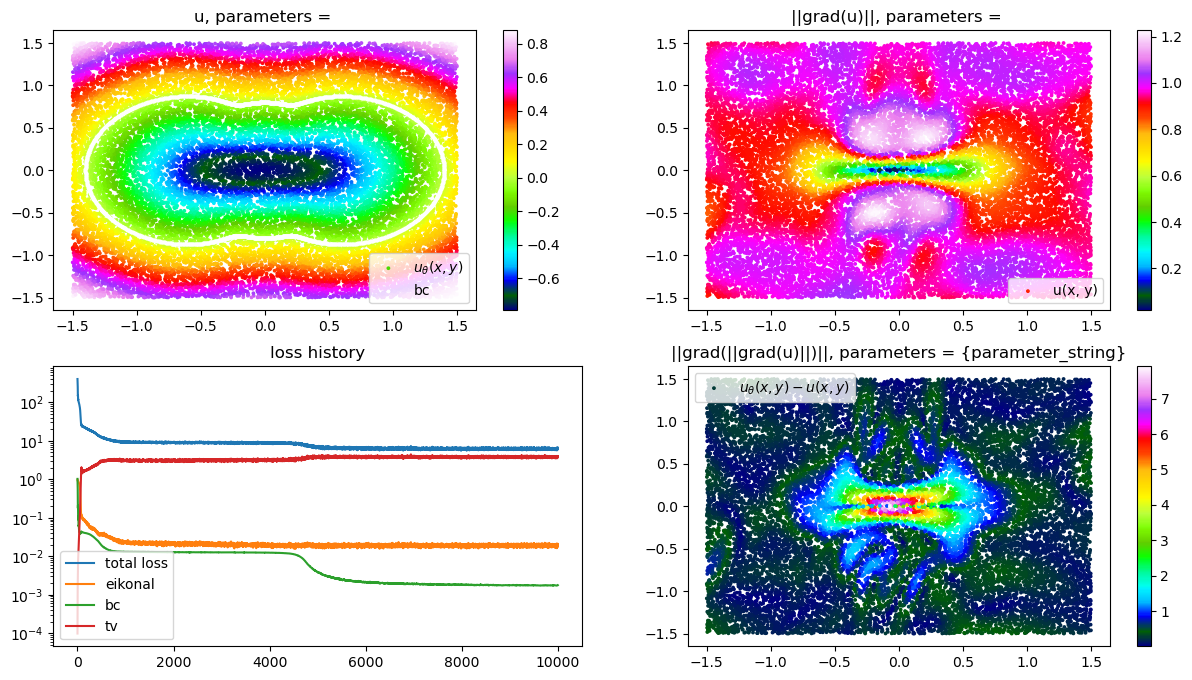

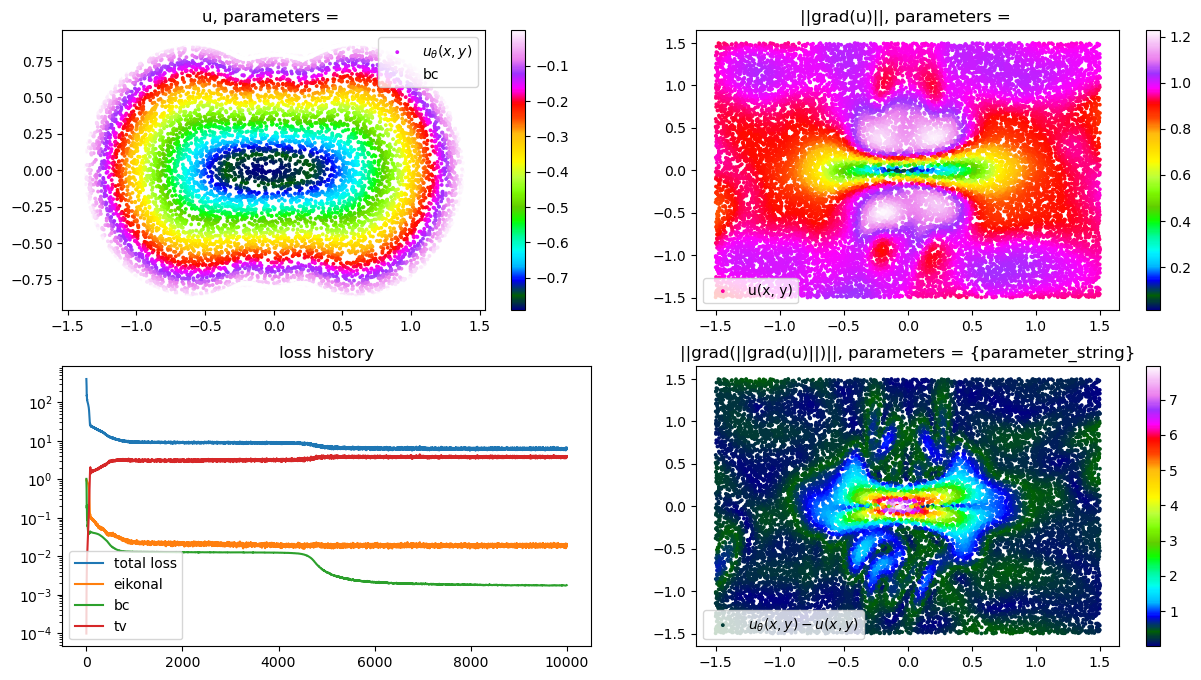

In [6]:
dict_config = read_config(config_filename)

eik,trainer = sdf_run(form,num_config,dict_config,new_training = False,createxyzfile=False)

## Dérivées

Compute derivatives :

In [7]:
def derivees_torch(u_pred,x,derive,direction):
    first_derivatives = grad_torch(u_pred["w"].sum(), x, create_graph=True)[0]
    du_dx = first_derivatives[:, 0]
    du_dy = first_derivatives[:, 1]
    if derive == 1:
        if direction == "x":
            return du_dx
        elif direction == "y":
            return du_dy
        else:
            ValueError("direction = 'x' or 'y'")
    elif derive == 2: 
        if direction == "x":
            second_derivatives_x = grad_torch(du_dx.sum(), x, create_graph=True)[0]
            return second_derivatives_x[:, 0]
        elif direction == "y":
            second_derivatives_y = grad_torch(du_dy.sum(), x, create_graph=True)[0]
            return second_derivatives_y[:, 1]
        else:
            ValueError("direction = 'x' or 'y'")
    else:
        ValueError("derive = 1 or 2")

Get the PINNs prediction :

In [8]:
n_visu = 10000
X_test = trainer.sampler.sampling_x(n_visu)
shape = (n_visu, trainer.pde.nb_parameters)
ones = torch.ones(shape)
if trainer.pde.nb_parameters != 0:
    mu_test = torch.mean(trainer.pde.parameter_domain, axis=1) * ones
else:
    mu_test = torch.tensor([])

# get u_PINNs
pred = trainer.network.setup_w_dict(X_test, mu_test)
sdf_learned = pred["w"][:,0].cpu().detach().numpy()

Compute derivatives :

In [9]:
derive,direction = 1,"x"
du_dx = derivees_torch(pred,X_test,derive,direction)

derive,direction = 1,"y"
du_dy = derivees_torch(pred,X_test,derive,direction)

derive,direction = 2,"x"
d2u_dx2 = derivees_torch(pred,X_test,derive,direction)

derive,direction = 2,"y"
d2u_dy2 = derivees_torch(pred,X_test,derive,direction)

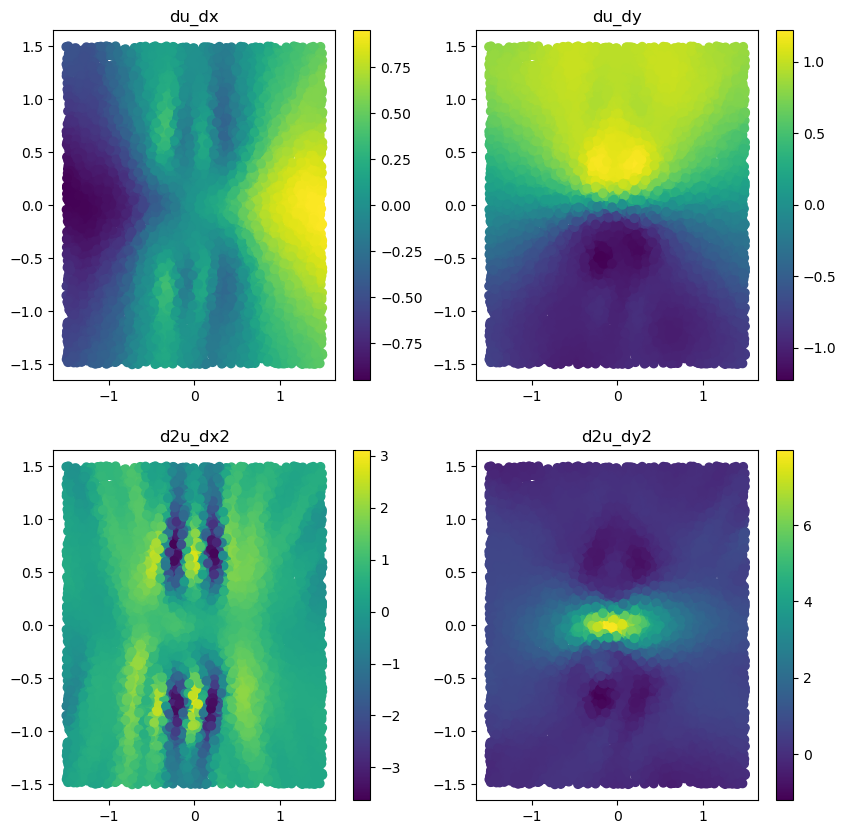

In [10]:
plt.figure(figsize=(10,10))

plt.subplot(221)
plt.scatter(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),c=du_dx.detach().numpy())
plt.colorbar()
plt.title("du_dx")

plt.subplot(222)
plt.scatter(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),c=du_dy.detach().numpy())
plt.colorbar()
plt.title("du_dy")

plt.subplot(223)
plt.scatter(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),c=d2u_dx2.detach().numpy())
plt.colorbar()
plt.title("d2u_dx2")

plt.subplot(224)
plt.scatter(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),c=d2u_dy2.detach().numpy())
plt.colorbar()
plt.title("d2u_dy2")

plt.savefig(derivees_dir+"derivees_"+str(num_config)+".png")
plt.show()
